# Simple q-learning agent with experience replay

We re-write q-learning algorithm using _agentnet_ - a helper for lasagne that implements some RL techniques.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS='floatX=float32'

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'


### Experiment setup
* Here we simply load the game and check that it works

In [2]:
import gym
make_env = lambda: gym.make("Acrobot-v1")

env=make_env()
env.reset()

state_shape = env.observation_space.shape
n_actions = env.action_space.n

[2017-03-18 23:35:16,471] Making new env: Acrobot-v1


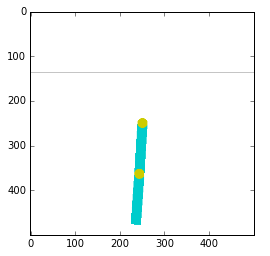

In [3]:
plt.imshow(env.render("rgb_array"))
del env

# Neural Network body

In [4]:
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import elu


#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,)+state_shape)
layer = DenseLayer(observation_layer, num_units=256, nonlinearity=elu)
layer = DenseLayer(layer, num_units=128, nonlinearity=elu)
qvalues_layer = DenseLayer(layer, num_units=n_actions, nonlinearity=None, name="q-values")

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

[2017-03-18 23:35:19,765] The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 730M (CNMeM is enabled with initial size: 70.0% of memory, cuDNN 5004)


Picking actions is done by yet another layer, that implements $ \epsilon$ -greedy policy

In [5]:
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)

#set starting epsilon
action_layer.epsilon.set_value(np.float32(0.05))

### Agent

We define an agent entirely composed of a lasagne network:
* Observations as InputLayer(s)
* Actions as intermediate Layer(s)
* `policy_estimators` is "whatever else you want to keep track of"

Each parameter can be either one layer or a list of layers

In [6]:
from agentnet.agent import Agent
agent = Agent(observation_layers=observation_layer,
              action_layers=action_layer,
              policy_estimators=qvalues_layer)

In [7]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[W, b, W, b, q-values.W, q-values.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [8]:
from agentnet.experiments.openai_gym.pool import EnvPool
pool = EnvPool(agent,make_env,n_games=1,max_size=10000)

[2017-03-18 23:35:34,123] Making new env: Acrobot-v1


In [9]:
%%time
#interact for 7 ticks
obs_log,action_log,reward_log,_,_,_  = pool.interact(5)


print('actions:',action_log)
print('rewards:',reward_log)

actions: [[2 2 2 2 0]]
rewards: [[-1. -1. -1. -1.  0.]]
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.93 ms


In [10]:
#we'll train on rollouts of 10 steps (required by n-step algorithms and rnns later)
SEQ_LENGTH=10

#load first sessions (this function calls interact and stores sessions in the pool)

for _ in range(100):
    pool.update(SEQ_LENGTH)

# q-learning

We shall now define a function that replays recent game sessions and updates network weights

In [11]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100)
qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)[-1]

In [12]:
#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2, like you implemented before in lasagne.

from agentnet.learning import qlearning
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,
                                                      n_steps=1,)

#compute mean loss over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [13]:
#get weight updates
updates = lasagne.updates.adam(loss,weights,learning_rate=1e-4)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

Play full session with an untrained agent

In [14]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2017-03-18 23:36:18,999] Making new env: Acrobot-v1
[2017-03-18 23:36:19,006] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-03-18 23:36:19,008] Starting new video recorder writing to /home/golovanov/repo/git/Practical_RL/week4/records/openaigym.video.0.31928.video000000.mp4
[2017-03-18 23:36:29,066] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')


Episode finished after 500 timesteps with reward=-500.0


In [15]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [16]:
epoch_counter = 1 #starting epoch
rewards = {} #full game rewards
target_score = -90

In [17]:
from tqdm import trange

for i in trange(10000):    
    
    #play
    for _ in range(5):
        pool.update(SEQ_LENGTH,append=True)
    
    #train
    train_step()
    
    #update epsilon
    epsilon = 0.05 + 0.95*np.exp(-epoch_counter/1000.)
    action_layer.epsilon.set_value(np.float32(epsilon))
    
    #play a few games for evaluation
    if epoch_counter%100==0:
        rewards[epoch_counter] = np.mean(pool.evaluate(n_games=3,record_video=False))
        print("iter=%i\tepsilon=%.3f"%(epoch_counter,action_layer.epsilon.get_value(),))
        print("Current score(mean over %i) = %.3f"%(3,np.mean(rewards[epoch_counter])))
    
        if rewards[epoch_counter] >= target_score:
            print("You win!")
            break

    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 99/10000 [00:06<10:37, 15.54it/s][2017-03-18 23:36:47,523] Making new env: Acrobot-v1
[2017-03-18 23:36:47,528] Clearing 4 monitor files from previous run (because force=True was provided)


Episode finished after 498 timesteps with reward=-497.0
Episode finished after 500 timesteps with reward=-500.0


[2017-03-18 23:36:48,947] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  1%|          | 101/10000 [00:08<46:23,  3.56it/s]

Episode finished after 500 timesteps with reward=-500.0
iter=100	epsilon=0.910
Current score(mean over 3) = -499.000


  2%|▏         | 199/10000 [00:14<10:36, 15.41it/s][2017-03-18 23:36:55,521] Making new env: Acrobot-v1
[2017-03-18 23:36:55,524] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 500 timesteps with reward=-500.0
Episode finished after 500 timesteps with reward=-500.0


[2017-03-18 23:36:56,971] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  2%|▏         | 201/10000 [00:16<46:52,  3.48it/s]

Episode finished after 500 timesteps with reward=-500.0
iter=200	epsilon=0.828
Current score(mean over 3) = -500.000


  3%|▎         | 299/10000 [00:23<11:16, 14.33it/s][2017-03-18 23:37:04,713] Making new env: Acrobot-v1
[2017-03-18 23:37:04,716] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 482 timesteps with reward=-481.0
Episode finished after 376 timesteps with reward=-375.0


[2017-03-18 23:37:05,882] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  3%|▎         | 301/10000 [00:25<40:21,  4.01it/s]

Episode finished after 361 timesteps with reward=-360.0
iter=300	epsilon=0.754
Current score(mean over 3) = -405.333


  4%|▍         | 399/10000 [00:32<11:41, 13.68it/s][2017-03-18 23:37:13,388] Making new env: Acrobot-v1
[2017-03-18 23:37:13,393] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 465 timesteps with reward=-464.0
Episode finished after 418 timesteps with reward=-417.0


[2017-03-18 23:37:14,680] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  4%|▍         | 401/10000 [00:33<42:46,  3.74it/s]

Episode finished after 500 timesteps with reward=-500.0
iter=400	epsilon=0.687
Current score(mean over 3) = -460.333


  5%|▍         | 499/10000 [00:40<10:29, 15.10it/s][2017-03-18 23:37:21,294] Making new env: Acrobot-v1
[2017-03-18 23:37:21,297] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 288 timesteps with reward=-287.0
Episode finished after 134 timesteps with reward=-133.0


[2017-03-18 23:37:22,212] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  5%|▌         | 501/10000 [00:41<34:33,  4.58it/s]

Episode finished after 359 timesteps with reward=-358.0
iter=500	epsilon=0.626
Current score(mean over 3) = -259.333


  6%|▌         | 598/10000 [00:49<14:00, 11.19it/s][2017-03-18 23:37:30,893] Making new env: Acrobot-v1
[2017-03-18 23:37:30,897] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 189 timesteps with reward=-188.0
Episode finished after 163 timesteps with reward=-162.0


[2017-03-18 23:37:31,446] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  6%|▌         | 602/10000 [00:50<22:10,  7.06it/s]

Episode finished after 222 timesteps with reward=-221.0
iter=600	epsilon=0.571
Current score(mean over 3) = -190.333


  7%|▋         | 698/10000 [00:58<12:07, 12.79it/s][2017-03-18 23:37:40,010] Making new env: Acrobot-v1
[2017-03-18 23:37:40,016] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 208 timesteps with reward=-207.0
Episode finished after 218 timesteps with reward=-217.0


[2017-03-18 23:37:40,662] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  7%|▋         | 702/10000 [00:59<23:00,  6.73it/s]

Episode finished after 246 timesteps with reward=-245.0
iter=700	epsilon=0.522
Current score(mean over 3) = -223.000


  8%|▊         | 799/10000 [01:07<15:20, 10.00it/s][2017-03-18 23:37:48,960] Making new env: Acrobot-v1
[2017-03-18 23:37:48,963] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 188 timesteps with reward=-187.0
Episode finished after 178 timesteps with reward=-177.0


[2017-03-18 23:37:49,526] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  8%|▊         | 801/10000 [01:08<28:03,  5.47it/s]

Episode finished after 155 timesteps with reward=-154.0
iter=800	epsilon=0.477
Current score(mean over 3) = -172.667


  9%|▉         | 898/10000 [01:17<12:34, 12.06it/s][2017-03-18 23:37:58,546] Making new env: Acrobot-v1
[2017-03-18 23:37:58,549] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 240 timesteps with reward=-239.0
Episode finished after 171 timesteps with reward=-170.0


[2017-03-18 23:37:59,128] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  9%|▉         | 901/10000 [01:18<22:55,  6.62it/s]

Episode finished after 204 timesteps with reward=-203.0
iter=900	epsilon=0.436
Current score(mean over 3) = -204.000


 10%|▉         | 999/10000 [01:26<11:53, 12.62it/s][2017-03-18 23:38:07,115] Making new env: Acrobot-v1
[2017-03-18 23:38:07,119] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 145 timesteps with reward=-144.0
Episode finished after 118 timesteps with reward=-117.0


[2017-03-18 23:38:07,550] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 10%|█         | 1001/10000 [01:26<22:22,  6.70it/s]

Episode finished after 151 timesteps with reward=-150.0
iter=1000	epsilon=0.399
Current score(mean over 3) = -137.000


 11%|█         | 1099/10000 [01:35<12:18, 12.05it/s][2017-03-18 23:38:16,054] Making new env: Acrobot-v1
[2017-03-18 23:38:16,057] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 174 timesteps with reward=-173.0
Episode finished after 170 timesteps with reward=-169.0


[2017-03-18 23:38:16,555] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 11%|█         | 1101/10000 [01:35<24:11,  6.13it/s]

Episode finished after 184 timesteps with reward=-183.0
iter=1100	epsilon=0.366
Current score(mean over 3) = -175.000


 12%|█▏        | 1199/10000 [01:44<12:29, 11.74it/s][2017-03-18 23:38:25,234] Making new env: Acrobot-v1
[2017-03-18 23:38:25,238] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 132 timesteps with reward=-131.0
Episode finished after 117 timesteps with reward=-116.0


[2017-03-18 23:38:25,582] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 12%|█▏        | 1201/10000 [01:44<20:25,  7.18it/s]

Episode finished after 111 timesteps with reward=-110.0
iter=1200	epsilon=0.336
Current score(mean over 3) = -119.000


 13%|█▎        | 1298/10000 [01:53<12:25, 11.67it/s][2017-03-18 23:38:34,301] Making new env: Acrobot-v1
[2017-03-18 23:38:34,305] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 115 timesteps with reward=-114.0
Episode finished after 111 timesteps with reward=-110.0


[2017-03-18 23:38:34,737] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 13%|█▎        | 1301/10000 [01:53<20:31,  7.07it/s]

Episode finished after 214 timesteps with reward=-213.0
iter=1300	epsilon=0.309
Current score(mean over 3) = -145.667


 14%|█▍        | 1398/10000 [02:03<12:58, 11.05it/s][2017-03-18 23:38:44,201] Making new env: Acrobot-v1
[2017-03-18 23:38:44,205] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 214 timesteps with reward=-213.0


[2017-03-18 23:38:44,883] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 14%|█▍        | 1400/10000 [02:03<27:28,  5.22it/s]

Episode finished after 303 timesteps with reward=-302.0
Episode finished after 151 timesteps with reward=-150.0
iter=1400	epsilon=0.284
Current score(mean over 3) = -221.667


 15%|█▍        | 1498/10000 [02:13<13:13, 10.72it/s][2017-03-18 23:38:54,342] Making new env: Acrobot-v1
[2017-03-18 23:38:54,346] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 141 timesteps with reward=-140.0
Episode finished after 206 timesteps with reward=-205.0


[2017-03-18 23:38:54,826] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 15%|█▌        | 1501/10000 [02:13<21:05,  6.71it/s]

Episode finished after 136 timesteps with reward=-135.0
iter=1500	epsilon=0.262
Current score(mean over 3) = -160.000


 16%|█▌        | 1599/10000 [02:24<21:49,  6.41it/s][2017-03-18 23:39:05,983] Making new env: Acrobot-v1
[2017-03-18 23:39:05,988] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 94 timesteps with reward=-93.0
Episode finished after 120 timesteps with reward=-119.0


[2017-03-18 23:39:06,516] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 16%|█▌        | 1600/10000 [02:25<44:07,  3.17it/s]

Episode finished after 94 timesteps with reward=-93.0
iter=1600	epsilon=0.242
Current score(mean over 3) = -101.667


 17%|█▋        | 1699/10000 [02:37<16:30,  8.38it/s][2017-03-18 23:39:18,406] Making new env: Acrobot-v1
[2017-03-18 23:39:18,409] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 141 timesteps with reward=-140.0
Episode finished after 143 timesteps with reward=-142.0


[2017-03-18 23:39:18,924] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 17%|█▋        | 1701/10000 [02:38<30:36,  4.52it/s]

Episode finished after 241 timesteps with reward=-240.0
iter=1700	epsilon=0.224
Current score(mean over 3) = -174.000


 18%|█▊        | 1798/10000 [02:47<13:31, 10.11it/s][2017-03-18 23:39:29,062] Making new env: Acrobot-v1
[2017-03-18 23:39:29,065] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 191 timesteps with reward=-190.0
Episode finished after 135 timesteps with reward=-134.0


[2017-03-18 23:39:29,602] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 18%|█▊        | 1801/10000 [02:48<22:16,  6.13it/s]

Episode finished after 220 timesteps with reward=-219.0
iter=1800	epsilon=0.207
Current score(mean over 3) = -181.000


 19%|█▉        | 1899/10000 [02:58<13:49,  9.76it/s][2017-03-18 23:39:39,936] Making new env: Acrobot-v1
[2017-03-18 23:39:39,940] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 100 timesteps with reward=-99.0
Episode finished after 113 timesteps with reward=-112.0


[2017-03-18 23:39:40,324] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 19%|█▉        | 1901/10000 [02:59<25:31,  5.29it/s]

Episode finished after 152 timesteps with reward=-151.0
iter=1900	epsilon=0.192
Current score(mean over 3) = -120.667


 20%|█▉        | 1999/10000 [03:09<13:39,  9.76it/s][2017-03-18 23:39:50,771] Making new env: Acrobot-v1
[2017-03-18 23:39:50,775] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-18 23:39:51,236] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 20%|██        | 2000/10000 [03:10<32:07,  4.15it/s]

Episode finished after 313 timesteps with reward=-312.0
Episode finished after 101 timesteps with reward=-100.0
Episode finished after 90 timesteps with reward=-89.0
iter=2000	epsilon=0.179
Current score(mean over 3) = -167.000


 21%|██        | 2099/10000 [03:20<13:48,  9.54it/s][2017-03-18 23:40:01,767] Making new env: Acrobot-v1
[2017-03-18 23:40:01,771] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 337 timesteps with reward=-336.0
Episode finished after 320 timesteps with reward=-319.0


[2017-03-18 23:40:02,776] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 21%|██        | 2101/10000 [03:21<42:44,  3.08it/s]

Episode finished after 415 timesteps with reward=-414.0
iter=2100	epsilon=0.166
Current score(mean over 3) = -356.333


 22%|██▏       | 2199/10000 [03:34<15:32,  8.37it/s][2017-03-18 23:40:15,143] Making new env: Acrobot-v1
[2017-03-18 23:40:15,146] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 249 timesteps with reward=-248.0


[2017-03-18 23:40:15,870] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 22%|██▏       | 2200/10000 [03:34<44:01,  2.95it/s]

Episode finished after 289 timesteps with reward=-288.0
Episode finished after 218 timesteps with reward=-217.0
iter=2200	epsilon=0.155
Current score(mean over 3) = -251.000


 23%|██▎       | 2299/10000 [03:46<14:31,  8.83it/s][2017-03-18 23:40:27,146] Making new env: Acrobot-v1
[2017-03-18 23:40:27,150] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 388 timesteps with reward=-387.0
Episode finished after 160 timesteps with reward=-159.0


[2017-03-18 23:40:27,891] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 23%|██▎       | 2301/10000 [03:47<35:07,  3.65it/s]

Episode finished after 251 timesteps with reward=-250.0
iter=2300	epsilon=0.145
Current score(mean over 3) = -265.333


 24%|██▍       | 2399/10000 [03:57<13:32,  9.36it/s][2017-03-18 23:40:38,388] Making new env: Acrobot-v1
[2017-03-18 23:40:38,391] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 197 timesteps with reward=-196.0
Episode finished after 137 timesteps with reward=-136.0


[2017-03-18 23:40:38,902] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 24%|██▍       | 2401/10000 [03:58<27:59,  4.52it/s]

Episode finished after 215 timesteps with reward=-214.0
iter=2400	epsilon=0.136
Current score(mean over 3) = -182.000


 25%|██▍       | 2499/10000 [04:08<13:04,  9.56it/s][2017-03-18 23:40:49,482] Making new env: Acrobot-v1
[2017-03-18 23:40:49,486] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 136 timesteps with reward=-135.0
Episode finished after 124 timesteps with reward=-123.0


[2017-03-18 23:40:50,182] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 25%|██▌       | 2501/10000 [04:09<32:14,  3.88it/s]

Episode finished after 500 timesteps with reward=-500.0
iter=2500	epsilon=0.128
Current score(mean over 3) = -252.667


 26%|██▌       | 2599/10000 [04:20<14:30,  8.50it/s][2017-03-18 23:41:01,256] Making new env: Acrobot-v1
[2017-03-18 23:41:01,260] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 105 timesteps with reward=-104.0
Episode finished after 138 timesteps with reward=-137.0


[2017-03-18 23:41:01,705] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 26%|██▌       | 2601/10000 [04:20<26:21,  4.68it/s]

Episode finished after 135 timesteps with reward=-134.0
iter=2600	epsilon=0.121
Current score(mean over 3) = -125.000


 27%|██▋       | 2699/10000 [04:31<18:34,  6.55it/s][2017-03-18 23:41:12,718] Making new env: Acrobot-v1
[2017-03-18 23:41:12,726] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 114 timesteps with reward=-113.0


[2017-03-18 23:41:13,230] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 27%|██▋       | 2700/10000 [04:32<39:07,  3.11it/s]

Episode finished after 89 timesteps with reward=-88.0
Episode finished after 83 timesteps with reward=-82.0
iter=2700	epsilon=0.114
Current score(mean over 3) = -94.333


 28%|██▊       | 2799/10000 [04:45<13:44,  8.74it/s][2017-03-18 23:41:26,618] Making new env: Acrobot-v1
[2017-03-18 23:41:26,623] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-18 23:41:26,925] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 28%|██▊       | 2800/10000 [04:45<25:03,  4.79it/s]

Episode finished after 125 timesteps with reward=-124.0
Episode finished after 94 timesteps with reward=-93.0
Episode finished after 89 timesteps with reward=-88.0
iter=2800	epsilon=0.108
Current score(mean over 3) = -101.667


 29%|██▉       | 2899/10000 [04:56<13:00,  9.09it/s][2017-03-18 23:41:37,377] Making new env: Acrobot-v1
[2017-03-18 23:41:37,381] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 138 timesteps with reward=-137.0
Episode finished after 207 timesteps with reward=-206.0


[2017-03-18 23:41:37,866] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 29%|██▉       | 2901/10000 [04:57<25:30,  4.64it/s]

Episode finished after 168 timesteps with reward=-167.0
iter=2900	epsilon=0.102
Current score(mean over 3) = -170.000


 30%|██▉       | 2999/10000 [05:07<13:20,  8.75it/s][2017-03-18 23:41:48,405] Making new env: Acrobot-v1
[2017-03-18 23:41:48,408] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 124 timesteps with reward=-123.0
Episode finished after 132 timesteps with reward=-131.0


[2017-03-18 23:41:48,758] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 30%|███       | 3001/10000 [05:07<21:48,  5.35it/s]

Episode finished after 106 timesteps with reward=-105.0
iter=3000	epsilon=0.097
Current score(mean over 3) = -119.667


 31%|███       | 3099/10000 [05:18<12:28,  9.22it/s][2017-03-18 23:41:59,389] Making new env: Acrobot-v1
[2017-03-18 23:41:59,393] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-18 23:41:59,703] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 31%|███       | 3100/10000 [05:18<23:03,  4.99it/s]

Episode finished after 112 timesteps with reward=-111.0
Episode finished after 111 timesteps with reward=-110.0
Episode finished after 87 timesteps with reward=-86.0
iter=3100	epsilon=0.093
Current score(mean over 3) = -102.333


 32%|███▏      | 3199/10000 [05:29<12:14,  9.26it/s][2017-03-18 23:42:10,351] Making new env: Acrobot-v1
[2017-03-18 23:42:10,354] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-18 23:42:10,720] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 32%|███▏      | 3200/10000 [05:29<24:28,  4.63it/s]

Episode finished after 180 timesteps with reward=-179.0
Episode finished after 115 timesteps with reward=-114.0
Episode finished after 98 timesteps with reward=-97.0
iter=3200	epsilon=0.089
Current score(mean over 3) = -130.000


 33%|███▎      | 3299/10000 [05:40<12:17,  9.08it/s][2017-03-18 23:42:21,407] Making new env: Acrobot-v1
[2017-03-18 23:42:21,410] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 139 timesteps with reward=-138.0
Episode finished after 131 timesteps with reward=-130.0


[2017-03-18 23:42:21,763] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 33%|███▎      | 3301/10000 [05:40<21:14,  5.26it/s]

Episode finished after 112 timesteps with reward=-111.0
iter=3300	epsilon=0.085
Current score(mean over 3) = -126.333


 34%|███▍      | 3399/10000 [05:52<14:31,  7.58it/s][2017-03-18 23:42:33,460] Making new env: Acrobot-v1
[2017-03-18 23:42:33,463] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 110 timesteps with reward=-109.0
Episode finished after 104 timesteps with reward=-103.0


[2017-03-18 23:42:33,953] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 34%|███▍      | 3401/10000 [05:53<25:11,  4.37it/s]

Episode finished after 108 timesteps with reward=-107.0
iter=3400	epsilon=0.082
Current score(mean over 3) = -106.333


 35%|███▍      | 3499/10000 [06:05<12:59,  8.34it/s][2017-03-18 23:42:46,758] Making new env: Acrobot-v1
[2017-03-18 23:42:46,762] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 104 timesteps with reward=-103.0
Episode finished after 191 timesteps with reward=-190.0


[2017-03-18 23:42:47,213] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 35%|███▌      | 3501/10000 [06:06<23:43,  4.57it/s]

Episode finished after 174 timesteps with reward=-173.0
iter=3500	epsilon=0.079
Current score(mean over 3) = -155.333


 36%|███▌      | 3599/10000 [06:20<11:18,  9.44it/s][2017-03-18 23:43:01,872] Making new env: Acrobot-v1
[2017-03-18 23:43:01,875] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-18 23:43:02,194] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 36%|███▌      | 3600/10000 [06:21<21:49,  4.89it/s]

Episode finished after 108 timesteps with reward=-107.0
Episode finished after 121 timesteps with reward=-120.0
Episode finished after 104 timesteps with reward=-103.0
iter=3600	epsilon=0.076
Current score(mean over 3) = -110.000


 37%|███▋      | 3699/10000 [06:32<11:01,  9.52it/s][2017-03-18 23:43:13,322] Making new env: Acrobot-v1
[2017-03-18 23:43:13,326] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 75 timesteps with reward=-74.0
Episode finished after 92 timesteps with reward=-91.0


[2017-03-18 23:43:13,642] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 37%|███▋      | 3701/10000 [06:32<19:08,  5.48it/s]

Episode finished after 165 timesteps with reward=-164.0
iter=3700	epsilon=0.073
Current score(mean over 3) = -109.667


 38%|███▊      | 3799/10000 [06:43<10:58,  9.42it/s][2017-03-18 23:43:24,119] Making new env: Acrobot-v1
[2017-03-18 23:43:24,122] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 122 timesteps with reward=-121.0
Episode finished after 180 timesteps with reward=-179.0


[2017-03-18 23:43:24,606] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 38%|███▊      | 3801/10000 [06:43<21:32,  4.80it/s]

Episode finished after 183 timesteps with reward=-182.0
iter=3800	epsilon=0.071
Current score(mean over 3) = -160.667


 39%|███▉      | 3899/10000 [06:54<11:09,  9.11it/s][2017-03-18 23:43:35,248] Making new env: Acrobot-v1
[2017-03-18 23:43:35,253] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-18 23:43:35,549] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 39%|███▉      | 3900/10000 [06:54<20:34,  4.94it/s]

Episode finished after 89 timesteps with reward=-88.0
Episode finished after 120 timesteps with reward=-119.0
Episode finished after 94 timesteps with reward=-93.0
iter=3900	epsilon=0.069
Current score(mean over 3) = -100.000


 40%|███▉      | 3999/10000 [07:05<10:40,  9.37it/s][2017-03-18 23:43:46,247] Making new env: Acrobot-v1
[2017-03-18 23:43:46,252] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 412 timesteps with reward=-411.0
Episode finished after 334 timesteps with reward=-333.0


[2017-03-18 23:43:47,127] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 40%|████      | 4001/10000 [07:06<29:37,  3.38it/s]

Episode finished after 248 timesteps with reward=-247.0
iter=4000	epsilon=0.067
Current score(mean over 3) = -330.333


 41%|████      | 4099/10000 [07:16<10:06,  9.73it/s][2017-03-18 23:43:57,709] Making new env: Acrobot-v1
[2017-03-18 23:43:57,712] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 500 timesteps with reward=-500.0
Episode finished after 172 timesteps with reward=-171.0


[2017-03-18 23:43:58,561] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 41%|████      | 4101/10000 [07:17<28:12,  3.48it/s]

Episode finished after 229 timesteps with reward=-228.0
iter=4100	epsilon=0.066
Current score(mean over 3) = -299.667


 42%|████▏     | 4199/10000 [07:28<10:26,  9.26it/s][2017-03-18 23:44:09,365] Making new env: Acrobot-v1
[2017-03-18 23:44:09,368] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 228 timesteps with reward=-227.0
Episode finished after 136 timesteps with reward=-135.0


[2017-03-18 23:44:09,890] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 42%|████▏     | 4201/10000 [07:29<21:27,  4.50it/s]

Episode finished after 165 timesteps with reward=-164.0
iter=4200	epsilon=0.064
Current score(mean over 3) = -175.333


 43%|████▎     | 4299/10000 [07:39<09:56,  9.56it/s][2017-03-18 23:44:20,569] Making new env: Acrobot-v1
[2017-03-18 23:44:20,573] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-18 23:44:20,932] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 43%|████▎     | 4300/10000 [07:39<20:01,  4.74it/s]

Episode finished after 158 timesteps with reward=-157.0
Episode finished after 101 timesteps with reward=-100.0
Episode finished after 119 timesteps with reward=-118.0
iter=4300	epsilon=0.063
Current score(mean over 3) = -125.000


 44%|████▍     | 4399/10000 [07:50<09:57,  9.37it/s][2017-03-18 23:44:31,790] Making new env: Acrobot-v1
[2017-03-18 23:44:31,794] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 170 timesteps with reward=-169.0
Episode finished after 190 timesteps with reward=-189.0


[2017-03-18 23:44:32,341] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 44%|████▍     | 4401/10000 [07:51<21:34,  4.32it/s]

Episode finished after 158 timesteps with reward=-157.0
iter=4400	epsilon=0.062
Current score(mean over 3) = -171.667


 45%|████▍     | 4499/10000 [08:02<10:10,  9.00it/s][2017-03-18 23:44:43,402] Making new env: Acrobot-v1
[2017-03-18 23:44:43,404] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 147 timesteps with reward=-146.0
Episode finished after 133 timesteps with reward=-132.0


[2017-03-18 23:44:43,818] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 45%|████▌     | 4501/10000 [08:02<18:51,  4.86it/s]

Episode finished after 131 timesteps with reward=-130.0
iter=4500	epsilon=0.061
Current score(mean over 3) = -136.000


 46%|████▌     | 4599/10000 [08:13<09:46,  9.21it/s][2017-03-18 23:44:54,943] Making new env: Acrobot-v1
[2017-03-18 23:44:54,947] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 173 timesteps with reward=-172.0


[2017-03-18 23:44:55,642] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 46%|████▌     | 4600/10000 [08:14<28:23,  3.17it/s]

Episode finished after 302 timesteps with reward=-301.0
Episode finished after 175 timesteps with reward=-174.0
iter=4600	epsilon=0.060
Current score(mean over 3) = -215.667


 47%|████▋     | 4699/10000 [08:26<18:07,  4.88it/s][2017-03-18 23:45:07,765] Making new env: Acrobot-v1
[2017-03-18 23:45:07,768] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 121 timesteps with reward=-120.0
Episode finished after 113 timesteps with reward=-112.0


[2017-03-18 23:45:08,515] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 47%|████▋     | 4701/10000 [08:27<28:09,  3.14it/s]

Episode finished after 134 timesteps with reward=-133.0
iter=4700	epsilon=0.059
Current score(mean over 3) = -121.667


 48%|████▊     | 4799/10000 [08:39<10:15,  8.45it/s][2017-03-18 23:45:20,906] Making new env: Acrobot-v1
[2017-03-18 23:45:20,909] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 121 timesteps with reward=-120.0
Episode finished after 121 timesteps with reward=-120.0


[2017-03-18 23:45:21,303] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 48%|████▊     | 4801/10000 [08:40<18:08,  4.78it/s]

Episode finished after 113 timesteps with reward=-112.0
iter=4800	epsilon=0.058
Current score(mean over 3) = -117.333


 49%|████▉     | 4899/10000 [08:50<08:38,  9.84it/s][2017-03-18 23:45:31,587] Making new env: Acrobot-v1
[2017-03-18 23:45:31,591] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-18 23:45:31,927] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 49%|████▉     | 4900/10000 [08:50<17:17,  4.92it/s]

Episode finished after 134 timesteps with reward=-133.0
Episode finished after 102 timesteps with reward=-101.0
Episode finished after 129 timesteps with reward=-128.0
iter=4900	epsilon=0.057
Current score(mean over 3) = -120.667


 50%|████▉     | 4999/10000 [09:01<09:06,  9.16it/s][2017-03-18 23:45:42,359] Making new env: Acrobot-v1
[2017-03-18 23:45:42,362] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 234 timesteps with reward=-233.0


[2017-03-18 23:45:43,161] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 50%|█████     | 5000/10000 [09:02<29:14,  2.85it/s]

Episode finished after 453 timesteps with reward=-452.0
Episode finished after 192 timesteps with reward=-191.0
iter=5000	epsilon=0.056
Current score(mean over 3) = -292.000


 51%|█████     | 5098/10000 [09:12<09:00,  9.08it/s][2017-03-18 23:45:53,676] Making new env: Acrobot-v1
[2017-03-18 23:45:53,681] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-18 23:45:54,007] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 51%|█████     | 5100/10000 [09:13<12:47,  6.39it/s]

Episode finished after 134 timesteps with reward=-133.0
Episode finished after 101 timesteps with reward=-100.0
Episode finished after 121 timesteps with reward=-120.0
iter=5100	epsilon=0.056
Current score(mean over 3) = -117.667


 52%|█████▏    | 5198/10000 [09:23<08:42,  9.20it/s][2017-03-18 23:46:04,683] Making new env: Acrobot-v1
[2017-03-18 23:46:04,689] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 327 timesteps with reward=-326.0
Episode finished after 289 timesteps with reward=-288.0


[2017-03-18 23:46:05,674] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 52%|█████▏    | 5201/10000 [09:24<17:13,  4.65it/s]

Episode finished after 400 timesteps with reward=-399.0
iter=5200	epsilon=0.055
Current score(mean over 3) = -337.667


 53%|█████▎    | 5299/10000 [09:35<08:19,  9.41it/s][2017-03-18 23:46:16,151] Making new env: Acrobot-v1
[2017-03-18 23:46:16,156] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 189 timesteps with reward=-188.0
Episode finished after 113 timesteps with reward=-112.0


[2017-03-18 23:46:16,670] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 53%|█████▎    | 5301/10000 [09:35<16:42,  4.69it/s]

Episode finished after 225 timesteps with reward=-224.0
iter=5300	epsilon=0.055
Current score(mean over 3) = -174.667


 54%|█████▍    | 5398/10000 [09:45<08:14,  9.31it/s][2017-03-18 23:46:27,064] Making new env: Acrobot-v1
[2017-03-18 23:46:27,067] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-18 23:46:27,429] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 54%|█████▍    | 5400/10000 [09:46<12:18,  6.23it/s]

Episode finished after 157 timesteps with reward=-156.0
Episode finished after 108 timesteps with reward=-107.0
Episode finished after 112 timesteps with reward=-111.0
iter=5400	epsilon=0.054
Current score(mean over 3) = -124.667


 55%|█████▍    | 5499/10000 [09:56<07:46,  9.65it/s][2017-03-18 23:46:37,799] Making new env: Acrobot-v1
[2017-03-18 23:46:37,804] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-18 23:46:38,115] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 55%|█████▌    | 5500/10000 [09:57<14:56,  5.02it/s]

Episode finished after 109 timesteps with reward=-108.0
Episode finished after 101 timesteps with reward=-100.0
Episode finished after 109 timesteps with reward=-108.0
iter=5500	epsilon=0.054
Current score(mean over 3) = -105.333


 56%|█████▌    | 5598/10000 [10:07<07:16, 10.09it/s][2017-03-18 23:46:48,282] Making new env: Acrobot-v1
[2017-03-18 23:46:48,286] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 123 timesteps with reward=-122.0
Episode finished after 83 timesteps with reward=-82.0


[2017-03-18 23:46:48,790] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 56%|█████▌    | 5601/10000 [10:07<11:46,  6.23it/s]

Episode finished after 307 timesteps with reward=-306.0
iter=5600	epsilon=0.054
Current score(mean over 3) = -170.000


 57%|█████▋    | 5699/10000 [10:18<07:29,  9.57it/s][2017-03-18 23:46:59,146] Making new env: Acrobot-v1
[2017-03-18 23:46:59,149] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 206 timesteps with reward=-205.0
Episode finished after 171 timesteps with reward=-170.0


[2017-03-18 23:46:59,727] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 57%|█████▋    | 5701/10000 [10:18<16:42,  4.29it/s]

Episode finished after 250 timesteps with reward=-249.0
iter=5700	epsilon=0.053
Current score(mean over 3) = -208.000


 58%|█████▊    | 5799/10000 [10:29<07:12,  9.70it/s][2017-03-18 23:47:10,209] Making new env: Acrobot-v1
[2017-03-18 23:47:10,213] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 221 timesteps with reward=-220.0
Episode finished after 200 timesteps with reward=-199.0


[2017-03-18 23:47:10,839] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 58%|█████▊    | 5801/10000 [10:29<16:52,  4.15it/s]

Episode finished after 248 timesteps with reward=-247.0
iter=5800	epsilon=0.053
Current score(mean over 3) = -222.000


 59%|█████▉    | 5898/10000 [10:40<07:16,  9.40it/s][2017-03-18 23:47:21,498] Making new env: Acrobot-v1
[2017-03-18 23:47:21,501] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 406 timesteps with reward=-405.0
Episode finished after 500 timesteps with reward=-500.0


[2017-03-18 23:47:22,604] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 59%|█████▉    | 5901/10000 [10:41<15:20,  4.46it/s]

Episode finished after 276 timesteps with reward=-275.0
iter=5900	epsilon=0.053
Current score(mean over 3) = -393.333


 60%|█████▉    | 5999/10000 [10:52<06:55,  9.62it/s][2017-03-18 23:47:33,272] Making new env: Acrobot-v1
[2017-03-18 23:47:33,275] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 407 timesteps with reward=-406.0
Episode finished after 181 timesteps with reward=-180.0


[2017-03-18 23:47:34,035] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 60%|██████    | 6001/10000 [10:53<18:07,  3.68it/s]

Episode finished after 209 timesteps with reward=-208.0
iter=6000	epsilon=0.052
Current score(mean over 3) = -264.667


 61%|██████    | 6099/10000 [11:03<07:00,  9.27it/s][2017-03-18 23:47:44,411] Making new env: Acrobot-v1
[2017-03-18 23:47:44,415] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 244 timesteps with reward=-243.0
Episode finished after 105 timesteps with reward=-104.0


[2017-03-18 23:47:44,863] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 61%|██████    | 6101/10000 [11:04<13:42,  4.74it/s]

Episode finished after 126 timesteps with reward=-125.0
iter=6100	epsilon=0.052
Current score(mean over 3) = -157.333


 62%|██████▏   | 6199/10000 [11:14<06:44,  9.40it/s][2017-03-18 23:47:55,474] Making new env: Acrobot-v1
[2017-03-18 23:47:55,477] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 213 timesteps with reward=-212.0
Episode finished after 98 timesteps with reward=-97.0


[2017-03-18 23:47:55,994] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 62%|██████▏   | 6201/10000 [11:15<13:45,  4.60it/s]

Episode finished after 215 timesteps with reward=-214.0
iter=6200	epsilon=0.052
Current score(mean over 3) = -174.333


 63%|██████▎   | 6299/10000 [11:25<06:34,  9.39it/s][2017-03-18 23:48:06,522] Making new env: Acrobot-v1
[2017-03-18 23:48:06,525] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 294 timesteps with reward=-293.0
Episode finished after 140 timesteps with reward=-139.0


[2017-03-18 23:48:07,092] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 63%|██████▎   | 6301/10000 [11:26<14:24,  4.28it/s]

Episode finished after 174 timesteps with reward=-173.0
iter=6300	epsilon=0.052
Current score(mean over 3) = -201.667


 64%|██████▍   | 6398/10000 [11:36<06:22,  9.42it/s][2017-03-18 23:48:17,761] Making new env: Acrobot-v1
[2017-03-18 23:48:17,764] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 196 timesteps with reward=-195.0
Episode finished after 208 timesteps with reward=-207.0


[2017-03-18 23:48:18,340] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 64%|██████▍   | 6401/10000 [11:37<10:11,  5.88it/s]

Episode finished after 167 timesteps with reward=-166.0
iter=6400	epsilon=0.052
Current score(mean over 3) = -189.333


 65%|██████▍   | 6499/10000 [11:47<06:06,  9.56it/s][2017-03-18 23:48:28,948] Making new env: Acrobot-v1
[2017-03-18 23:48:28,951] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 104 timesteps with reward=-103.0
Episode finished after 102 timesteps with reward=-101.0


[2017-03-18 23:48:29,335] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 65%|██████▌   | 6501/10000 [11:48<11:19,  5.15it/s]

Episode finished after 173 timesteps with reward=-172.0
iter=6500	epsilon=0.051
Current score(mean over 3) = -125.333


 66%|██████▌   | 6599/10000 [11:58<06:01,  9.41it/s][2017-03-18 23:48:40,064] Making new env: Acrobot-v1
[2017-03-18 23:48:40,068] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-18 23:48:40,356] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 66%|██████▌   | 6600/10000 [11:59<11:07,  5.09it/s]

Episode finished after 90 timesteps with reward=-89.0
Episode finished after 99 timesteps with reward=-98.0
Episode finished after 89 timesteps with reward=-88.0
iter=6600	epsilon=0.051
Current score(mean over 3) = -91.667


 67%|██████▋   | 6699/10000 [12:09<05:46,  9.54it/s][2017-03-18 23:48:50,845] Making new env: Acrobot-v1
[2017-03-18 23:48:50,848] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 408 timesteps with reward=-407.0
Episode finished after 208 timesteps with reward=-207.0


[2017-03-18 23:48:51,754] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 67%|██████▋   | 6701/10000 [12:10<16:38,  3.31it/s]

Episode finished after 363 timesteps with reward=-362.0
iter=6700	epsilon=0.051
Current score(mean over 3) = -325.333


 68%|██████▊   | 6799/10000 [12:21<05:47,  9.21it/s][2017-03-18 23:49:02,485] Making new env: Acrobot-v1
[2017-03-18 23:49:02,488] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 218 timesteps with reward=-217.0
Episode finished after 128 timesteps with reward=-127.0


[2017-03-18 23:49:02,900] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 68%|██████▊   | 6801/10000 [12:22<10:42,  4.98it/s]

Episode finished after 114 timesteps with reward=-113.0
iter=6800	epsilon=0.051
Current score(mean over 3) = -152.333


 69%|██████▉   | 6899/10000 [12:32<05:26,  9.49it/s][2017-03-18 23:49:13,431] Making new env: Acrobot-v1
[2017-03-18 23:49:13,435] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-18 23:49:13,725] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 69%|██████▉   | 6900/10000 [12:32<09:57,  5.19it/s]

Episode finished after 103 timesteps with reward=-102.0
Episode finished after 111 timesteps with reward=-110.0
Episode finished after 76 timesteps with reward=-75.0
iter=6900	epsilon=0.051
Current score(mean over 3) = -95.667


 70%|██████▉   | 6999/10000 [12:45<07:40,  6.51it/s][2017-03-18 23:49:26,162] Making new env: Acrobot-v1
[2017-03-18 23:49:26,167] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 91 timesteps with reward=-90.0
Episode finished after 113 timesteps with reward=-112.0


[2017-03-18 23:49:26,647] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 70%|███████   | 7001/10000 [12:45<12:16,  4.07it/s]

Episode finished after 153 timesteps with reward=-152.0
iter=7000	epsilon=0.051
Current score(mean over 3) = -118.000


 71%|███████   | 7099/10000 [12:56<05:05,  9.48it/s][2017-03-18 23:49:37,297] Making new env: Acrobot-v1
[2017-03-18 23:49:37,301] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-18 23:49:37,542] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')


Episode finished after 81 timesteps with reward=-80.0
Episode finished after 85 timesteps with reward=-84.0
Episode finished after 74 timesteps with reward=-73.0
iter=7100	epsilon=0.051
Current score(mean over 3) = -79.000
You win!


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  app.launch_new_instance()


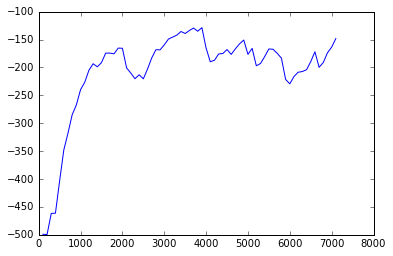

In [19]:
from pandas import ewma
iters,session_rewards=zip(*sorted(rewards.items(),key=lambda k: k[0]))
plt.plot(iters,ewma(np.array(session_rewards),span=10))

In [20]:
final_reward = pool.evaluate(n_games=10,save_path="./records",record_video=True)

print("average reward:",final_reward)

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

for video_name in video_names:
    HTML("""
    <video width="640" height="480" controls>
      <source src="{}" type="video/mp4">
    </video>
    """.format("./records/"+video_name)) #this may or may not be _last_ video. Try other indices

[2017-03-18 23:56:40,683] Making new env: Acrobot-v1
[2017-03-18 23:56:40,689] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-18 23:56:40,692] Starting new video recorder writing to /home/golovanov/repo/git/Practical_RL/week4/records/openaigym.video.72.31928.video000000.mp4
[2017-03-18 23:56:42,664] Starting new video recorder writing to /home/golovanov/repo/git/Practical_RL/week4/records/openaigym.video.72.31928.video000001.mp4


Episode finished after 86 timesteps with reward=-85.0
Episode finished after 75 timesteps with reward=-74.0
Episode finished after 99 timesteps with reward=-98.0
Episode finished after 124 timesteps with reward=-123.0
Episode finished after 76 timesteps with reward=-75.0
Episode finished after 117 timesteps with reward=-116.0
Episode finished after 127 timesteps with reward=-126.0


[2017-03-18 23:56:44,977] Starting new video recorder writing to /home/golovanov/repo/git/Practical_RL/week4/records/openaigym.video.72.31928.video000008.mp4


Episode finished after 136 timesteps with reward=-135.0
Episode finished after 97 timesteps with reward=-96.0


[2017-03-18 23:56:47,166] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')


Episode finished after 162 timesteps with reward=-161.0
average reward: [-85.0, -74.0, -98.0, -123.0, -75.0, -116.0, -126.0, -135.0, -96.0, -161.0]


## Homework part I (5+ pts)

Train a neural network for [`LunarLander-v2`](https://gym.openai.com/envs/LunarLander-v2).
* Getting average reward of at least +0 gets you 5 points
* Higher reward = more points


## Bonus I
* Try getting the same [or better] results on Acrobot __(+2 pts)__ or __LunarLander (+3 pts)__ using on-policy methods
* You can get n-step q-learning by messing with ```n_steps``` param in the q-learning code above
* Note that using large experience replay buffer will slow down on-policy algorithms to almost zero, so it's probably a good idea to use small experience replay buffer with several parallel agents

In [48]:
import gym
make_env = lambda: gym.make("LunarLander-v2")

env = make_env()
env.reset()

state_shape = env.observation_space.shape
n_actions = env.action_space.n

[2017-03-19 09:11:50,387] Making new env: LunarLander-v2


In [78]:
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import rectify

observation_layer = InputLayer((None,) + state_shape)
layer = DenseLayer(observation_layer, num_units=320, nonlinearity=rectify, W=lasagne.init.HeNormal())
layer = DenseLayer(layer, num_units=256, nonlinearity=rectify, W=lasagne.init.HeNormal())
layer = DenseLayer(layer, num_units=128, nonlinearity=rectify, W=lasagne.init.HeNormal())
qvalues_layer = DenseLayer(layer, num_units=n_actions, nonlinearity=None)

In [79]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet import Agent

action_layer = EpsilonGreedyResolver(qvalues_layer)

agent = Agent(observation_layers=observation_layer, 
              policy_estimators=qvalues_layer, 
              action_layers=action_layer)

params = lasagne.layers.get_all_params(action_layer, trainable=True)

In [80]:
import theano
from agentnet.experiments.openai_gym.pool import EnvPool
from agentnet.learning import qlearning

SEQ_LENGTH = 7
gamma = 0.98
n_steps = 1

pool = EnvPool(agent, make_env, n_games=20, max_size=int(5 * 1e4))

replay = pool.experience_replay.sample_session_batch(1024)
qvalues_seq = agent.get_sessions(replay, session_length=SEQ_LENGTH, experience_replay=True)[-1]
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=gamma,
                                                      n_steps=n_steps)

#compute mean loss over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

updates = lasagne.updates.adam(loss, params)
train_step = theano.function([], loss, updates=updates)

[2017-03-19 10:25:10,443] Making new env: LunarLander-v2
[2017-03-19 10:25:10,452] Making new env: LunarLander-v2
[2017-03-19 10:25:10,460] Making new env: LunarLander-v2
[2017-03-19 10:25:10,465] Making new env: LunarLander-v2
[2017-03-19 10:25:10,471] Making new env: LunarLander-v2
[2017-03-19 10:25:10,477] Making new env: LunarLander-v2
[2017-03-19 10:25:10,481] Making new env: LunarLander-v2
[2017-03-19 10:25:10,484] Making new env: LunarLander-v2
[2017-03-19 10:25:10,489] Making new env: LunarLander-v2
[2017-03-19 10:25:10,493] Making new env: LunarLander-v2
[2017-03-19 10:25:10,496] Making new env: LunarLander-v2
[2017-03-19 10:25:10,500] Making new env: LunarLander-v2
[2017-03-19 10:25:10,505] Making new env: LunarLander-v2
[2017-03-19 10:25:10,511] Making new env: LunarLander-v2
[2017-03-19 10:25:10,515] Making new env: LunarLander-v2
[2017-03-19 10:25:10,519] Making new env: LunarLander-v2
[2017-03-19 10:25:10,524] Making new env: LunarLander-v2
[2017-03-19 10:25:10,539] Makin

In [81]:
import numpy as np
from tqdm import trange

epoch_counter = 1
rewards = {}

for i in trange(50000):    
    
    #update epsilon
    epsilon = 1.0 * np.exp(-epoch_counter / 1000.)
    action_layer.epsilon.set_value(np.float32(epsilon))
    
    #play
    for _ in range(3):
        pool.update(SEQ_LENGTH, append=True)
    
    #train
    train_step()
    
    #play a few games for evaluation
    if epoch_counter % 200 == 0:
        rewards[epoch_counter] = np.mean(pool.evaluate(n_games=3, record_video=False))
        print("iter=%i\tepsilon=%.3f"%(epoch_counter,action_layer.epsilon.get_value(),))
        print("Current score(mean over %i) = %.3f"%(3, np.mean(rewards[epoch_counter])))
    
    epoch_counter += 1

  0%|          | 0/50000 [00:00<?, ?it/s]/usr/local/lib/python3.4/dist-packages/agentnet/utils/logging.py:14: UserWarning: [Verbose>=1] Warning! Appending sessions to empty or broken pool. Old pool sessions, if any, are disposed.
  default_warn("[Verbose>=%s] %s"%(verbosity_level,message),**kwargs)
  0%|          | 199/50000 [00:41<2:41:44,  5.13it/s][2017-03-19 10:26:06,983] Making new env: LunarLander-v2
[2017-03-19 10:26:06,987] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-19 10:26:07,329] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  0%|          | 200/50000 [00:41<4:09:16,  3.33it/s]

Episode finished after 138 timesteps with reward=-170.17923481739177
Episode finished after 133 timesteps with reward=-334.13526722231074
Episode finished after 74 timesteps with reward=-105.53917802869762
iter=200	epsilon=0.819
Current score(mean over 3) = -203.285


  1%|          | 399/50000 [01:20<2:46:37,  4.96it/s][2017-03-19 10:26:46,014] Making new env: LunarLander-v2
[2017-03-19 10:26:46,018] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-19 10:26:46,329] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  1%|          | 400/50000 [01:20<4:04:49,  3.38it/s]

Episode finished after 100 timesteps with reward=-83.95091080432175
Episode finished after 70 timesteps with reward=-183.3654698443488
Episode finished after 139 timesteps with reward=-130.50803985915329
iter=400	epsilon=0.670
Current score(mean over 3) = -132.608


  1%|          | 599/50000 [02:11<4:26:00,  3.10it/s][2017-03-19 10:27:37,711] Making new env: LunarLander-v2
[2017-03-19 10:27:37,715] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 141 timesteps with reward=-104.99001924464997
Episode finished after 157 timesteps with reward=-29.71938636853291


[2017-03-19 10:27:38,133] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  1%|          | 600/50000 [02:12<6:12:21,  2.21it/s]

Episode finished after 117 timesteps with reward=-114.69652260417594
iter=600	epsilon=0.549
Current score(mean over 3) = -83.135


  2%|▏         | 799/50000 [04:16<9:23:20,  1.46it/s][2017-03-19 10:29:42,257] Making new env: LunarLander-v2
[2017-03-19 10:29:42,262] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 232 timesteps with reward=-108.11192298230645
Episode finished after 238 timesteps with reward=-163.10103963927784


[2017-03-19 10:29:43,701] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  2%|▏         | 800/50000 [04:18<15:15:51,  1.12s/it]

Episode finished after 274 timesteps with reward=-101.26638547156341
iter=800	epsilon=0.449
Current score(mean over 3) = -124.160


  2%|▏         | 999/50000 [07:00<9:39:47,  1.41it/s][2017-03-19 10:32:27,187] Making new env: LunarLander-v2
[2017-03-19 10:32:27,192] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 116 timesteps with reward=-70.40463277346782
Episode finished after 1000 timesteps with reward=-54.53962833261677


[2017-03-19 10:32:32,892] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  2%|▏         | 1000/50000 [07:07<33:15:44,  2.44s/it]

Episode finished after 423 timesteps with reward=-41.42215791748836
iter=1000	epsilon=0.368
Current score(mean over 3) = -55.455


  2%|▏         | 1199/50000 [10:05<12:29:44,  1.08it/s][2017-03-19 10:35:31,458] Making new env: LunarLander-v2
[2017-03-19 10:35:31,462] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 230 timesteps with reward=-92.3865271359185
Episode finished after 1000 timesteps with reward=4.689624009816125


[2017-03-19 10:35:38,161] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  2%|▏         | 1200/50000 [10:12<39:24:22,  2.91s/it]

Episode finished after 514 timesteps with reward=-268.5509128191722
iter=1200	epsilon=0.301
Current score(mean over 3) = -118.749


  3%|▎         | 1399/50000 [13:25<12:48:26,  1.05it/s][2017-03-19 10:38:52,335] Making new env: LunarLander-v2
[2017-03-19 10:38:52,339] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=39.85463437260588
Episode finished after 1000 timesteps with reward=86.51181585819157


[2017-03-19 10:39:05,589] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  3%|▎         | 1400/50000 [13:40<66:46:42,  4.95s/it]

Episode finished after 1000 timesteps with reward=-41.22588123962123
iter=1400	epsilon=0.247
Current score(mean over 3) = 28.380


  3%|▎         | 1599/50000 [16:34<13:25:22,  1.00it/s][2017-03-19 10:42:00,530] Making new env: LunarLander-v2
[2017-03-19 10:42:00,535] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-33.47362986009936
Episode finished after 1000 timesteps with reward=-165.01631318104148


[2017-03-19 10:42:12,378] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  3%|▎         | 1600/50000 [16:46<61:12:04,  4.55s/it]

Episode finished after 1000 timesteps with reward=-60.3368886676344
iter=1600	epsilon=0.202
Current score(mean over 3) = -86.276


  4%|▎         | 1799/50000 [19:41<12:01:13,  1.11it/s][2017-03-19 10:45:07,445] Making new env: LunarLander-v2
[2017-03-19 10:45:07,449] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-182.50125869335142
Episode finished after 1000 timesteps with reward=-98.0898469095257


[2017-03-19 10:45:19,190] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  4%|▎         | 1800/50000 [19:53<59:30:10,  4.44s/it]

Episode finished after 1000 timesteps with reward=-128.30793721343844
iter=1800	epsilon=0.165
Current score(mean over 3) = -136.300


  4%|▍         | 1999/50000 [23:06<11:20:51,  1.18it/s][2017-03-19 10:48:32,635] Making new env: LunarLander-v2
[2017-03-19 10:48:32,639] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-66.66093854229078
Episode finished after 1000 timesteps with reward=-143.35306111870565


[2017-03-19 10:48:45,015] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  4%|▍         | 2000/50000 [23:19<60:42:21,  4.55s/it]

Episode finished after 1000 timesteps with reward=-43.81153013270185
iter=2000	epsilon=0.135
Current score(mean over 3) = -84.609


  4%|▍         | 2199/50000 [26:35<15:13:37,  1.15s/it][2017-03-19 10:52:01,775] Making new env: LunarLander-v2
[2017-03-19 10:52:01,779] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-145.50467398048968
Episode finished after 1000 timesteps with reward=-148.82032576035996


[2017-03-19 10:52:15,885] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  4%|▍         | 2200/50000 [26:50<70:22:08,  5.30s/it]

Episode finished after 1000 timesteps with reward=-126.75344127477763
iter=2200	epsilon=0.111
Current score(mean over 3) = -140.359


  5%|▍         | 2399/50000 [29:57<11:18:53,  1.17it/s][2017-03-19 10:55:23,459] Making new env: LunarLander-v2
[2017-03-19 10:55:23,464] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-93.07384890766242
Episode finished after 1000 timesteps with reward=-147.57691805895925


[2017-03-19 10:55:36,426] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  5%|▍         | 2400/50000 [30:11<63:04:19,  4.77s/it]

Episode finished after 1000 timesteps with reward=-44.54940272459027
iter=2400	epsilon=0.091
Current score(mean over 3) = -95.067


  5%|▌         | 2599/50000 [33:19<9:42:27,  1.36it/s][2017-03-19 10:58:46,030] Making new env: LunarLander-v2
[2017-03-19 10:58:46,033] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-50.26522962754735
Episode finished after 1000 timesteps with reward=-137.78649400573573


[2017-03-19 10:58:51,956] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  5%|▌         | 2600/50000 [33:26<33:05:40,  2.51s/it]

Episode finished after 1000 timesteps with reward=-106.98961245883358
iter=2600	epsilon=0.074
Current score(mean over 3) = -98.347


  6%|▌         | 2799/50000 [36:30<12:33:05,  1.04it/s][2017-03-19 11:01:56,657] Making new env: LunarLander-v2
[2017-03-19 11:01:56,661] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 638 timesteps with reward=-219.5022102421185
Episode finished after 726 timesteps with reward=-220.70358285063878


[2017-03-19 11:02:04,498] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  6%|▌         | 2800/50000 [36:39<43:03:05,  3.28s/it]

Episode finished after 1000 timesteps with reward=-115.15662070874983
iter=2800	epsilon=0.061
Current score(mean over 3) = -185.121


  6%|▌         | 2999/50000 [39:39<15:28:42,  1.19s/it][2017-03-19 11:05:05,704] Making new env: LunarLander-v2
[2017-03-19 11:05:05,709] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-60.85881173195088
Episode finished after 1000 timesteps with reward=-125.21942705240771


[2017-03-19 11:05:17,355] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  6%|▌         | 3000/50000 [39:51<61:00:05,  4.67s/it]

Episode finished after 1000 timesteps with reward=-83.9922497106966
iter=3000	epsilon=0.050
Current score(mean over 3) = -90.023


  6%|▋         | 3199/50000 [43:03<10:12:05,  1.27it/s][2017-03-19 11:08:29,993] Making new env: LunarLander-v2
[2017-03-19 11:08:29,997] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-54.917886606044156
Episode finished after 1000 timesteps with reward=-36.041427448049106


[2017-03-19 11:08:46,113] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  6%|▋         | 3200/50000 [43:20<72:44:28,  5.60s/it]

Episode finished after 1000 timesteps with reward=-83.61032224625625
iter=3200	epsilon=0.041
Current score(mean over 3) = -58.190


  7%|▋         | 3399/50000 [46:33<12:12:28,  1.06it/s][2017-03-19 11:11:59,975] Making new env: LunarLander-v2
[2017-03-19 11:11:59,979] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-145.18914832603286
Episode finished after 148 timesteps with reward=-144.30942048992165


[2017-03-19 11:12:09,634] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  7%|▋         | 3400/50000 [46:44<49:46:23,  3.85s/it]

Episode finished after 1000 timesteps with reward=-157.50769212673623
iter=3400	epsilon=0.033
Current score(mean over 3) = -149.002


  7%|▋         | 3599/50000 [49:44<11:23:15,  1.13it/s][2017-03-19 11:15:11,111] Making new env: LunarLander-v2
[2017-03-19 11:15:11,115] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-58.81914044967604
Episode finished after 1000 timesteps with reward=-103.01765177276376


[2017-03-19 11:15:22,765] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  7%|▋         | 3600/50000 [49:57<55:55:41,  4.34s/it]

Episode finished after 1000 timesteps with reward=-28.063139041722188
iter=3600	epsilon=0.027
Current score(mean over 3) = -63.300


  8%|▊         | 3799/50000 [52:54<10:25:12,  1.23it/s][2017-03-19 11:18:21,017] Making new env: LunarLander-v2
[2017-03-19 11:18:21,021] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-82.78378200258393
Episode finished after 1000 timesteps with reward=-50.10301127375837


[2017-03-19 11:18:33,026] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  8%|▊         | 3800/50000 [53:07<56:20:26,  4.39s/it]

Episode finished after 1000 timesteps with reward=-62.531556761020575
iter=3800	epsilon=0.022
Current score(mean over 3) = -65.139


  8%|▊         | 3999/50000 [56:08<11:15:06,  1.14it/s][2017-03-19 11:21:34,919] Making new env: LunarLander-v2
[2017-03-19 11:21:34,923] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-93.36054800954933
Episode finished after 1000 timesteps with reward=-103.8512104879954


[2017-03-19 11:21:51,755] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  8%|▊         | 4000/50000 [56:26<75:44:26,  5.93s/it]

Episode finished after 1000 timesteps with reward=-141.41064133791076
iter=4000	epsilon=0.018
Current score(mean over 3) = -112.874


  8%|▊         | 4199/50000 [59:28<11:19:04,  1.12it/s][2017-03-19 11:24:54,475] Making new env: LunarLander-v2
[2017-03-19 11:24:54,481] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=15.988459638269697
Episode finished after 1000 timesteps with reward=-92.12364289573677


[2017-03-19 11:25:04,451] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  8%|▊         | 4200/50000 [59:39<48:59:16,  3.85s/it]

Episode finished after 1000 timesteps with reward=-83.88950068156963
iter=4200	epsilon=0.015
Current score(mean over 3) = -53.342


  9%|▉         | 4399/50000 [1:02:32<11:06:21,  1.14it/s][2017-03-19 11:27:58,468] Making new env: LunarLander-v2
[2017-03-19 11:27:58,472] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-26.145995113262043
Episode finished after 1000 timesteps with reward=-86.0960152359506


[2017-03-19 11:28:17,789] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  9%|▉         | 4400/50000 [1:02:52<84:30:05,  6.67s/it]

Episode finished after 1000 timesteps with reward=-58.528471059017996
iter=4400	epsilon=0.012
Current score(mean over 3) = -56.923


  9%|▉         | 4599/50000 [1:06:04<16:27:19,  1.30s/it][2017-03-19 11:31:30,916] Making new env: LunarLander-v2
[2017-03-19 11:31:30,923] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 485 timesteps with reward=158.84823238622147
Episode finished after 840 timesteps with reward=103.7714784758849


[2017-03-19 11:31:41,658] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
  9%|▉         | 4600/50000 [1:06:16<57:42:46,  4.58s/it]

Episode finished after 1000 timesteps with reward=-114.03509811662649
iter=4600	epsilon=0.010
Current score(mean over 3) = 49.528


 10%|▉         | 4799/50000 [1:09:33<11:45:11,  1.07it/s][2017-03-19 11:34:59,547] Making new env: LunarLander-v2
[2017-03-19 11:34:59,551] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 815 timesteps with reward=133.1023539255119
Episode finished after 1000 timesteps with reward=-126.65780300709606


[2017-03-19 11:35:12,487] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 10%|▉         | 4800/50000 [1:09:47<60:13:22,  4.80s/it]

Episode finished after 1000 timesteps with reward=-97.86623359839756
iter=4800	epsilon=0.008
Current score(mean over 3) = -30.474


 10%|▉         | 4999/50000 [1:12:46<12:29:10,  1.00it/s][2017-03-19 11:38:13,193] Making new env: LunarLander-v2
[2017-03-19 11:38:13,198] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-101.8641684773728
Episode finished after 1000 timesteps with reward=-104.64165703817872


[2017-03-19 11:38:28,011] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 10%|█         | 5000/50000 [1:13:02<68:17:23,  5.46s/it]

Episode finished after 316 timesteps with reward=162.56063926190248
iter=5000	epsilon=0.007
Current score(mean over 3) = -14.648


 10%|█         | 5199/50000 [1:16:06<8:52:33,  1.40it/s][2017-03-19 11:41:33,053] Making new env: LunarLander-v2
[2017-03-19 11:41:33,057] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-140.73605887620357
Episode finished after 1000 timesteps with reward=-86.78269004241501


[2017-03-19 11:41:43,716] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 10%|█         | 5200/50000 [1:16:18<48:58:37,  3.94s/it]

Episode finished after 1000 timesteps with reward=-100.34349875596459
iter=5200	epsilon=0.006
Current score(mean over 3) = -109.287


 11%|█         | 5399/50000 [1:18:56<9:06:09,  1.36it/s][2017-03-19 11:44:22,672] Making new env: LunarLander-v2
[2017-03-19 11:44:22,676] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 459 timesteps with reward=173.56765735649773
Episode finished after 1000 timesteps with reward=-101.2857417015861


[2017-03-19 11:44:30,554] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 11%|█         | 5400/50000 [1:19:05<38:32:30,  3.11s/it]

Episode finished after 1000 timesteps with reward=-108.87098051428994
iter=5400	epsilon=0.005
Current score(mean over 3) = -12.196


 11%|█         | 5599/50000 [1:21:29<9:03:06,  1.36it/s][2017-03-19 11:46:55,419] Making new env: LunarLander-v2
[2017-03-19 11:46:55,424] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 370 timesteps with reward=188.38492388038762
Episode finished after 397 timesteps with reward=211.1171135986777


[2017-03-19 11:46:57,768] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 11%|█         | 5600/50000 [1:21:32<17:41:38,  1.43s/it]

Episode finished after 659 timesteps with reward=141.23378620548485
iter=5600	epsilon=0.004
Current score(mean over 3) = 180.245


 12%|█▏        | 5799/50000 [1:23:24<8:02:18,  1.53it/s][2017-03-19 11:48:50,659] Making new env: LunarLander-v2
[2017-03-19 11:48:50,662] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-88.32691317821494
Episode finished after 215 timesteps with reward=11.647168348795361


[2017-03-19 11:48:55,184] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 12%|█▏        | 5800/50000 [1:23:29<24:41:30,  2.01s/it]

Episode finished after 1000 timesteps with reward=-152.86354058898098
iter=5800	epsilon=0.003
Current score(mean over 3) = -76.514


 12%|█▏        | 5999/50000 [1:25:44<8:47:37,  1.39it/s][2017-03-19 11:51:10,859] Making new env: LunarLander-v2
[2017-03-19 11:51:10,864] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-151.00030942225007
Episode finished after 1000 timesteps with reward=-133.59535690020215


[2017-03-19 11:51:18,317] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 12%|█▏        | 6000/50000 [1:25:52<35:42:31,  2.92s/it]

Episode finished after 229 timesteps with reward=-232.221089061246
iter=6000	epsilon=0.002
Current score(mean over 3) = -172.272


 12%|█▏        | 6199/50000 [1:27:57<10:17:13,  1.18it/s][2017-03-19 11:53:23,377] Making new env: LunarLander-v2
[2017-03-19 11:53:23,381] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-86.72815778915906
Episode finished after 1000 timesteps with reward=57.18434584315841


[2017-03-19 11:53:28,428] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 12%|█▏        | 6200/50000 [1:28:03<28:32:10,  2.35s/it]

Episode finished after 596 timesteps with reward=142.97330744963298
iter=6200	epsilon=0.002
Current score(mean over 3) = 37.810


 13%|█▎        | 6399/50000 [1:29:49<5:12:32,  2.33it/s][2017-03-19 11:55:15,071] Making new env: LunarLander-v2
[2017-03-19 11:55:15,075] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-256.7159679284065
Episode finished after 1000 timesteps with reward=-174.22588143177092


[2017-03-19 11:55:22,086] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 13%|█▎        | 6400/50000 [1:29:56<30:31:06,  2.52s/it]

Episode finished after 1000 timesteps with reward=-105.81485133821405
iter=6400	epsilon=0.002
Current score(mean over 3) = -178.919


 13%|█▎        | 6599/50000 [1:31:46<5:17:44,  2.28it/s][2017-03-19 11:57:12,565] Making new env: LunarLander-v2
[2017-03-19 11:57:12,569] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 264 timesteps with reward=237.50540145548808
Episode finished after 264 timesteps with reward=205.89898822047553


[2017-03-19 11:57:13,530] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 13%|█▎        | 6600/50000 [1:31:48<8:39:49,  1.39it/s]

Episode finished after 245 timesteps with reward=225.17558189313095
iter=6600	epsilon=0.001
Current score(mean over 3) = 222.860


 14%|█▎        | 6799/50000 [1:33:22<5:11:12,  2.31it/s][2017-03-19 11:58:48,521] Making new env: LunarLander-v2
[2017-03-19 11:58:48,525] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 235 timesteps with reward=199.48733247913583
Episode finished after 391 timesteps with reward=227.61862965407843


[2017-03-19 11:58:49,573] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 14%|█▎        | 6800/50000 [1:33:24<8:54:58,  1.35it/s]

Episode finished after 236 timesteps with reward=236.51611676633445
iter=6800	epsilon=0.001
Current score(mean over 3) = 221.207


 14%|█▍        | 6999/50000 [1:34:55<3:59:39,  2.99it/s][2017-03-19 12:00:21,099] Making new env: LunarLander-v2
[2017-03-19 12:00:21,103] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 240 timesteps with reward=200.6860137073555


[2017-03-19 12:00:21,970] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 14%|█▍        | 7000/50000 [1:34:56<7:00:25,  1.70it/s]

Episode finished after 381 timesteps with reward=227.3213528259944
Episode finished after 219 timesteps with reward=199.20716968645579
iter=7000	epsilon=0.001
Current score(mean over 3) = 209.072


 14%|█▍        | 7199/50000 [1:36:23<3:49:52,  3.10it/s][2017-03-19 12:01:49,266] Making new env: LunarLander-v2
[2017-03-19 12:01:49,270] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 200 timesteps with reward=194.84900556597222
Episode finished after 229 timesteps with reward=200.7032384455972


[2017-03-19 12:01:50,071] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 14%|█▍        | 7200/50000 [1:36:24<6:41:24,  1.78it/s]

Episode finished after 228 timesteps with reward=209.100790858531
iter=7200	epsilon=0.001
Current score(mean over 3) = 201.551


 15%|█▍        | 7399/50000 [1:37:34<5:26:54,  2.17it/s][2017-03-19 12:03:00,196] Making new env: LunarLander-v2
[2017-03-19 12:03:00,199] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 299 timesteps with reward=226.98715090812829
Episode finished after 260 timesteps with reward=232.8765839983575


[2017-03-19 12:03:01,294] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 15%|█▍        | 7400/50000 [1:37:35<9:25:04,  1.26it/s]

Episode finished after 325 timesteps with reward=208.92984068912722
iter=7400	epsilon=0.001
Current score(mean over 3) = 222.931


 15%|█▌        | 7599/50000 [1:38:53<5:16:23,  2.23it/s][2017-03-19 12:04:19,710] Making new env: LunarLander-v2
[2017-03-19 12:04:19,713] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 478 timesteps with reward=250.16642004539474
Episode finished after 194 timesteps with reward=179.3358307130244


[2017-03-19 12:04:20,652] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 15%|█▌        | 7600/50000 [1:38:55<8:03:23,  1.46it/s]

Episode finished after 125 timesteps with reward=202.90919059589137
iter=7600	epsilon=0.001
Current score(mean over 3) = 210.804


 16%|█▌        | 7799/50000 [1:40:21<3:43:09,  3.15it/s][2017-03-19 12:05:47,676] Making new env: LunarLander-v2
[2017-03-19 12:05:47,680] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-139.5521460832751
Episode finished after 370 timesteps with reward=171.84033629590985


[2017-03-19 12:05:50,605] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 16%|█▌        | 7800/50000 [1:40:25<14:02:56,  1.20s/it]

Episode finished after 545 timesteps with reward=197.33521454653442
iter=7800	epsilon=0.000
Current score(mean over 3) = 76.541


 16%|█▌        | 7999/50000 [1:41:41<4:44:39,  2.46it/s][2017-03-19 12:07:07,213] Making new env: LunarLander-v2
[2017-03-19 12:07:07,217] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 287 timesteps with reward=230.24666018103397
Episode finished after 156 timesteps with reward=209.30828949880296


[2017-03-19 12:07:07,951] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 16%|█▌        | 8000/50000 [1:41:42<7:18:25,  1.60it/s]

Episode finished after 221 timesteps with reward=240.5296446157113
iter=8000	epsilon=0.000
Current score(mean over 3) = 226.695


 16%|█▋        | 8199/50000 [1:42:46<3:38:21,  3.19it/s][2017-03-19 12:08:11,756] Making new env: LunarLander-v2
[2017-03-19 12:08:11,760] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 243 timesteps with reward=224.17873579195532


[2017-03-19 12:08:12,847] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 16%|█▋        | 8200/50000 [1:42:47<7:22:57,  1.57it/s]

Episode finished after 406 timesteps with reward=223.98548788281983
Episode finished after 197 timesteps with reward=230.4469060766768
iter=8200	epsilon=0.000
Current score(mean over 3) = 226.204


 17%|█▋        | 8399/50000 [1:43:55<3:32:11,  3.27it/s][2017-03-19 12:09:21,023] Making new env: LunarLander-v2
[2017-03-19 12:09:21,027] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 247 timesteps with reward=199.2872724158562
Episode finished after 235 timesteps with reward=240.83051911852516


[2017-03-19 12:09:21,715] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 17%|█▋        | 8400/50000 [1:43:56<6:00:28,  1.92it/s]

Episode finished after 204 timesteps with reward=203.76426821232343
iter=8400	epsilon=0.000
Current score(mean over 3) = 214.627


 17%|█▋        | 8599/50000 [1:45:20<3:14:00,  3.56it/s][2017-03-19 12:10:46,286] Making new env: LunarLander-v2
[2017-03-19 12:10:46,290] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 321 timesteps with reward=218.25556593219738
Episode finished after 375 timesteps with reward=185.54327517438855


[2017-03-19 12:10:47,592] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 17%|█▋        | 8600/50000 [1:45:22<7:46:14,  1.48it/s]

Episode finished after 366 timesteps with reward=203.7551625462669
iter=8600	epsilon=0.000
Current score(mean over 3) = 202.518


 18%|█▊        | 8799/50000 [1:46:37<3:37:05,  3.16it/s][2017-03-19 12:12:03,294] Making new env: LunarLander-v2
[2017-03-19 12:12:03,297] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 215 timesteps with reward=242.1176792895741
Episode finished after 265 timesteps with reward=208.45261071458427


[2017-03-19 12:12:04,168] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 18%|█▊        | 8800/50000 [1:46:38<6:34:31,  1.74it/s]

Episode finished after 217 timesteps with reward=235.2807746731774
iter=8800	epsilon=0.000
Current score(mean over 3) = 228.617


 18%|█▊        | 8999/50000 [1:47:49<5:02:48,  2.26it/s][2017-03-19 12:13:15,711] Making new env: LunarLander-v2
[2017-03-19 12:13:15,714] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 242 timesteps with reward=250.05790469737266
Episode finished after 190 timesteps with reward=254.15483482093396


[2017-03-19 12:13:16,396] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 18%|█▊        | 9000/50000 [1:47:50<7:25:30,  1.53it/s]

Episode finished after 210 timesteps with reward=205.10475269806884
iter=9000	epsilon=0.000
Current score(mean over 3) = 236.439


 18%|█▊        | 9199/50000 [1:49:03<3:53:26,  2.91it/s][2017-03-19 12:14:29,246] Making new env: LunarLander-v2
[2017-03-19 12:14:29,250] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 248 timesteps with reward=217.63867178973834
Episode finished after 286 timesteps with reward=197.44091782310875


[2017-03-19 12:14:30,364] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 18%|█▊        | 9200/50000 [1:49:04<7:44:29,  1.46it/s]

Episode finished after 306 timesteps with reward=243.91931470442856
iter=9200	epsilon=0.000
Current score(mean over 3) = 219.666


 19%|█▉        | 9399/50000 [1:50:17<4:04:26,  2.77it/s][2017-03-19 12:15:42,794] Making new env: LunarLander-v2
[2017-03-19 12:15:42,797] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-19 12:15:43,043] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 19%|█▉        | 9400/50000 [1:50:17<4:35:47,  2.45it/s]

Episode finished after 73 timesteps with reward=-37.46390076097744
Episode finished after 71 timesteps with reward=-59.591626576244565
Episode finished after 101 timesteps with reward=-21.378070057827102
iter=9400	epsilon=0.000
Current score(mean over 3) = -39.478


 19%|█▉        | 9599/50000 [1:51:53<4:29:07,  2.50it/s][2017-03-19 12:17:19,698] Making new env: LunarLander-v2
[2017-03-19 12:17:19,702] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 224 timesteps with reward=242.66629673899692
Episode finished after 228 timesteps with reward=225.43151084993153


[2017-03-19 12:17:20,541] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 19%|█▉        | 9600/50000 [1:51:55<7:23:43,  1.52it/s]

Episode finished after 267 timesteps with reward=191.74729278928748
iter=9600	epsilon=0.000
Current score(mean over 3) = 219.948


 20%|█▉        | 9799/50000 [1:53:20<3:30:48,  3.18it/s][2017-03-19 12:18:45,813] Making new env: LunarLander-v2
[2017-03-19 12:18:45,817] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 271 timesteps with reward=238.57312251940903
Episode finished after 187 timesteps with reward=198.48141826680816


[2017-03-19 12:18:47,736] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 20%|█▉        | 9800/50000 [1:53:22<10:00:41,  1.12it/s]

Episode finished after 1000 timesteps with reward=136.05671834316718
iter=9800	epsilon=0.000
Current score(mean over 3) = 191.037


 20%|█▉        | 9999/50000 [1:54:29<3:45:54,  2.95it/s][2017-03-19 12:19:55,542] Making new env: LunarLander-v2
[2017-03-19 12:19:55,546] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 215 timesteps with reward=213.6162104879262
Episode finished after 197 timesteps with reward=218.14019340774416


[2017-03-19 12:19:56,269] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 20%|██        | 10000/50000 [1:54:30<6:10:31,  1.80it/s]

Episode finished after 234 timesteps with reward=184.3217058891774
iter=10000	epsilon=0.000
Current score(mean over 3) = 205.359


 20%|██        | 10199/50000 [1:55:40<4:06:53,  2.69it/s][2017-03-19 12:21:05,816] Making new env: LunarLander-v2
[2017-03-19 12:21:05,820] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=129.4772585092444
Episode finished after 138 timesteps with reward=240.95465022313354


[2017-03-19 12:21:08,423] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 20%|██        | 10200/50000 [1:55:43<12:43:05,  1.15s/it]

Episode finished after 1000 timesteps with reward=110.0439054449575
iter=10200	epsilon=0.000
Current score(mean over 3) = 160.159


 21%|██        | 10399/50000 [1:56:52<3:21:15,  3.28it/s][2017-03-19 12:22:18,672] Making new env: LunarLander-v2
[2017-03-19 12:22:18,676] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 221 timesteps with reward=235.71866482650267


[2017-03-19 12:22:20,303] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 21%|██        | 10400/50000 [1:56:54<8:42:00,  1.26it/s]

Episode finished after 1000 timesteps with reward=92.7198886154706
Episode finished after 184 timesteps with reward=218.99436639826877
iter=10400	epsilon=0.000
Current score(mean over 3) = 182.478


 21%|██        | 10599/50000 [1:58:02<3:47:38,  2.88it/s][2017-03-19 12:23:28,047] Making new env: LunarLander-v2
[2017-03-19 12:23:28,051] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 218 timesteps with reward=192.33744177985128
Episode finished after 195 timesteps with reward=257.3032325661112


[2017-03-19 12:23:28,713] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 21%|██        | 10600/50000 [1:58:03<5:50:26,  1.87it/s]

Episode finished after 238 timesteps with reward=243.7034739521801
iter=10600	epsilon=0.000
Current score(mean over 3) = 231.115


 22%|██▏       | 10799/50000 [1:59:05<3:34:42,  3.04it/s][2017-03-19 12:24:31,753] Making new env: LunarLander-v2
[2017-03-19 12:24:31,756] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 526 timesteps with reward=154.80666596397703
Episode finished after 508 timesteps with reward=158.59700279300472


[2017-03-19 12:24:34,432] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 22%|██▏       | 10800/50000 [1:59:09<12:21:39,  1.14s/it]

Episode finished after 628 timesteps with reward=155.14012461014335
iter=10800	epsilon=0.000
Current score(mean over 3) = 156.181


 22%|██▏       | 10999/50000 [2:00:17<4:09:38,  2.60it/s][2017-03-19 12:25:43,260] Making new env: LunarLander-v2
[2017-03-19 12:25:43,264] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 167 timesteps with reward=194.1961314592427


[2017-03-19 12:25:44,153] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 22%|██▏       | 11000/50000 [2:00:18<7:00:48,  1.54it/s]

Episode finished after 410 timesteps with reward=-43.52502657740338
Episode finished after 146 timesteps with reward=237.9869216561785
iter=11000	epsilon=0.000
Current score(mean over 3) = 129.553


 22%|██▏       | 11199/50000 [2:01:21<3:14:42,  3.32it/s][2017-03-19 12:26:46,907] Making new env: LunarLander-v2
[2017-03-19 12:26:46,910] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 459 timesteps with reward=154.454918294388
Episode finished after 431 timesteps with reward=209.29439191153887


[2017-03-19 12:26:48,956] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 22%|██▏       | 11200/50000 [2:01:23<9:52:38,  1.09it/s]

Episode finished after 465 timesteps with reward=169.24487450660394
iter=11200	epsilon=0.000
Current score(mean over 3) = 177.665


 23%|██▎       | 11399/50000 [2:02:34<3:15:49,  3.29it/s][2017-03-19 12:28:00,322] Making new env: LunarLander-v2
[2017-03-19 12:28:00,326] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 167 timesteps with reward=232.2226739125845
Episode finished after 169 timesteps with reward=221.70620836448663


[2017-03-19 12:28:01,056] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 23%|██▎       | 11400/50000 [2:02:35<5:42:10,  1.88it/s]

Episode finished after 260 timesteps with reward=163.6687139971591
iter=11400	epsilon=0.000
Current score(mean over 3) = 205.866


 23%|██▎       | 11599/50000 [2:03:50<4:57:38,  2.15it/s][2017-03-19 12:29:16,537] Making new env: LunarLander-v2
[2017-03-19 12:29:16,541] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 168 timesteps with reward=207.41104715273997
Episode finished after 156 timesteps with reward=222.33383362881722


[2017-03-19 12:29:17,109] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 23%|██▎       | 11600/50000 [2:03:51<6:45:36,  1.58it/s]

Episode finished after 225 timesteps with reward=250.29179669380747
iter=11600	epsilon=0.000
Current score(mean over 3) = 226.679


 24%|██▎       | 11799/50000 [2:05:04<4:04:43,  2.60it/s][2017-03-19 12:30:29,866] Making new env: LunarLander-v2
[2017-03-19 12:30:29,870] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 234 timesteps with reward=235.11478183693495


[2017-03-19 12:30:30,541] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 24%|██▎       | 11800/50000 [2:05:05<6:14:53,  1.70it/s]

Episode finished after 224 timesteps with reward=234.5365207464682
Episode finished after 188 timesteps with reward=210.74173632370324
iter=11800	epsilon=0.000
Current score(mean over 3) = 226.798


 24%|██▍       | 11999/50000 [2:06:08<3:14:05,  3.26it/s][2017-03-19 12:31:33,726] Making new env: LunarLander-v2
[2017-03-19 12:31:33,729] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 246 timesteps with reward=205.2017796093204
Episode finished after 1000 timesteps with reward=87.74784885093504


[2017-03-19 12:31:35,966] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 24%|██▍       | 12000/50000 [2:06:10<10:19:53,  1.02it/s]

Episode finished after 210 timesteps with reward=202.11370588559507
iter=12000	epsilon=0.000
Current score(mean over 3) = 165.021


 24%|██▍       | 12199/50000 [2:07:18<4:03:19,  2.59it/s][2017-03-19 12:32:44,672] Making new env: LunarLander-v2
[2017-03-19 12:32:44,676] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 139 timesteps with reward=232.70469571050464


[2017-03-19 12:32:45,306] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 24%|██▍       | 12200/50000 [2:07:19<6:08:26,  1.71it/s]

Episode finished after 219 timesteps with reward=217.32248378351665
Episode finished after 185 timesteps with reward=228.95680564865518
iter=12200	epsilon=0.000
Current score(mean over 3) = 226.328


 25%|██▍       | 12399/50000 [2:08:29<3:46:31,  2.77it/s][2017-03-19 12:33:55,387] Making new env: LunarLander-v2
[2017-03-19 12:33:55,391] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=32.98998278112158
Episode finished after 645 timesteps with reward=92.26652779404895


[2017-03-19 12:34:00,326] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 25%|██▍       | 12400/50000 [2:08:34<19:27:41,  1.86s/it]

Episode finished after 909 timesteps with reward=139.07915073947248
iter=12400	epsilon=0.000
Current score(mean over 3) = 88.112


 25%|██▌       | 12599/50000 [2:10:12<5:46:59,  1.80it/s][2017-03-19 12:35:38,388] Making new env: LunarLander-v2
[2017-03-19 12:35:38,392] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-152.98992981026788
Episode finished after 199 timesteps with reward=199.7098149668782


[2017-03-19 12:35:41,104] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 25%|██▌       | 12600/50000 [2:10:15<14:25:11,  1.39s/it]

Episode finished after 208 timesteps with reward=217.87240888504442
iter=12600	epsilon=0.000
Current score(mean over 3) = 88.197


 26%|██▌       | 12799/50000 [2:11:49<3:45:01,  2.76it/s][2017-03-19 12:37:15,682] Making new env: LunarLander-v2
[2017-03-19 12:37:15,685] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 267 timesteps with reward=189.87969278753314
Episode finished after 294 timesteps with reward=192.33502427341296


[2017-03-19 12:37:16,751] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week4/records')
 26%|██▌       | 12800/50000 [2:11:51<7:07:12,  1.45it/s]

Episode finished after 330 timesteps with reward=201.83960092192973
iter=12800	epsilon=0.000
Current score(mean over 3) = 194.685


 26%|██▌       | 12947/50000 [2:12:42<4:29:47,  2.29it/s]


KeyboardInterrupt: 